# **ENTRENAMIENTO DEL MODELO PARA DETECCIÓN DE VIOLENCIA FÍSICA - TimeSformer**

# **1. Configuración Inicial y Preparación**

In [1]:
# Instalación de dependencias
# !pip install transformers==4.36.0
!pip install transformers
!pip install torch torchvision
!pip install scikit-learn
!pip install wandb
!pip install decord
!pip install einops
!pip install timm
!pip install seaborn
!pip install tqdm
!pip install pytorch-grad-cam  # Para Grad-CAM
!pip install onnx  # Para exportación a ONNX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 112.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [2]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-agz7dkmm
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-agz7dkmm
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=43669 sha256=b2482d6e4d85efe288d76d3f2b2d0da3e1f715ad502933dd072f576d31645ce0
  Stored in directory: /tmp/pip-ephem-wheel-cache-dp0lxb7t/wheels/a0/4d/c8/0502c44e32030c99ffab1b98075308a1ef9829c1835537afc6
Successfully built grad-cam


In [3]:
# Importar librerías
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import random
import wandb
import glob
import math
import cv2
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from transformers import TimesformerForVideoClassification, AutoImageProcessor
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
import decord
from decord import VideoReader, cpu
from einops import rearrange
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import onnx
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Configuración de rutas
BASE_PATH = '/content/drive/MyDrive/Proyecto-IA3'
DATASET_PATH = '/content/drive/MyDrive/dataset_violencia'
MODELS_PATH = f'{BASE_PATH}/models/timesformer'
CHECKPOINTS_PATH = f'{BASE_PATH}/checkpoints/timesformer'
RESULTS_PATH = f'{BASE_PATH}/results/timesformer'
LOGGS_PATH = f'{BASE_PATH}/logs/timesformer'

# Crear directorios
for path in [MODELS_PATH, CHECKPOINTS_PATH, RESULTS_PATH, LOGGS_PATH]:
    os.makedirs(path, exist_ok=True)

# Configuración de semillas para reproducibilidad
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seeds(42)

# Verificar GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla T4
Memory Available: 15.83 GB


# **2. Análisis y Visualización del Dataset**

Analizando dataset (versión rápida)...

Analizando train set:
  no_violencia: 2000 videos
  amenazante_ambigua: 2000 videos
  violencia_directa: 1998 videos

Analizando val set:
  no_violencia: 500 videos
  amenazante_ambigua: 500 videos
  violencia_directa: 499 videos

Analizando test set:
  no_violencia: 300 videos
  amenazante_ambigua: 300 videos
  violencia_directa: 299 videos


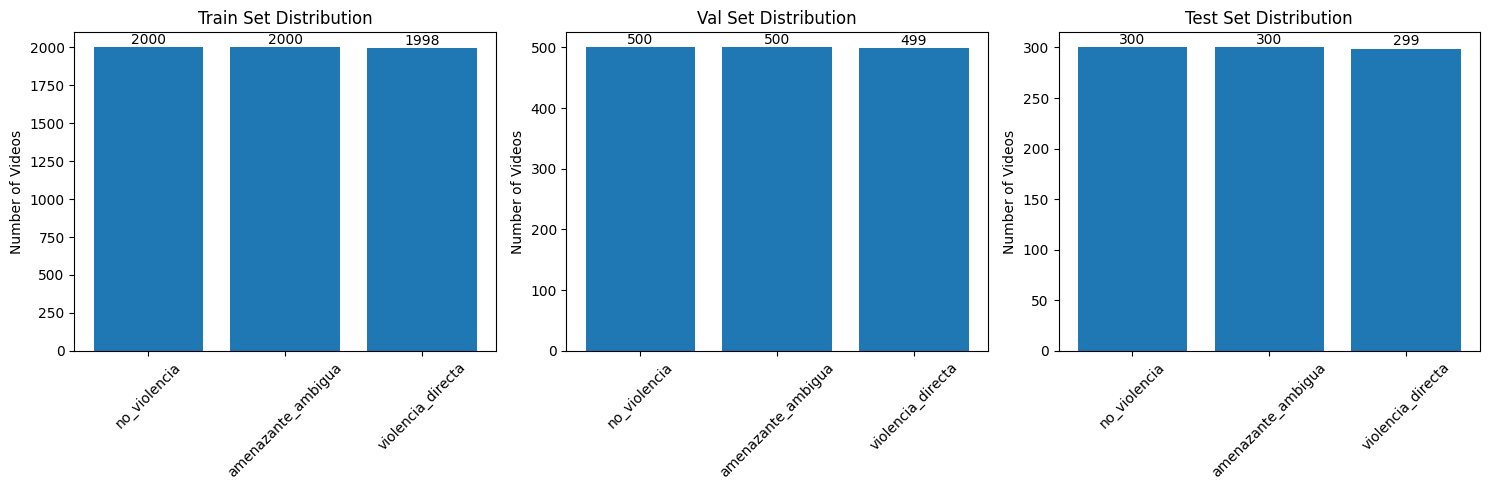

In [7]:
# Configuración de clases
CLASS_NAMES = ['no_violencia', 'amenazante_ambigua', 'violencia_directa']
NUM_CLASSES = len(CLASS_NAMES)

# Dataset personalizado para videos
class ViolenceVideoDataset(Dataset):
    def __init__(self, root_dir, split='train', num_frames=8, transform=None):
        self.root_dir = Path(root_dir) / split
        self.num_frames = num_frames
        self.transform = transform
        self.classes = CLASS_NAMES
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        # Cargar todos los videos
        self.video_paths = []
        self.labels = []

        for class_idx, class_name in enumerate(self.classes):
            class_dir = self.root_dir / class_name
            if class_dir.exists():
                for video_path in class_dir.glob('*.mp4'):
                    self.video_paths.append(str(video_path))
                    self.labels.append(class_idx)

        print(f"Loaded {len(self.video_paths)} videos for {split} split")

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]

        try:
            # Cargar video usando decord
            vr = VideoReader(video_path, ctx=cpu(0))
            total_frames = len(vr)

            # Verificar si el video tiene frames
            if total_frames == 0:
                raise ValueError(f"Video {video_path} has 0 frames")

            # Muestrear frames uniformemente
            if total_frames <= self.num_frames:
                frame_indices = list(range(total_frames))
                # Repetir frames si hay menos que num_frames
                while len(frame_indices) < self.num_frames:
                    frame_indices.extend(frame_indices[:self.num_frames - len(frame_indices)])
            else:
                # Muestreo uniforme
                frame_indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)

            # Obtener frames
            frames = vr.get_batch(frame_indices).asnumpy()

            # Convertir a formato requerido por TimesFormer [C, T, H, W]
            frames = rearrange(frames, 't h w c -> c t h w')
            frames = frames.astype(np.float32) / 255.0

            # Redimensionar a 224x224 si es necesario
            if frames.shape[-2:] != (224, 224):
                resized_frames = []
                for t in range(frames.shape[1]):
                    frame = frames[:, t, :, :]
                    frame = rearrange(frame, 'c h w -> h w c')
                    frame = cv2.resize(frame, (224, 224))
                    frame = rearrange(frame, 'h w c -> c h w')
                    resized_frames.append(frame)
                frames = np.stack(resized_frames, axis=1)

            frames = torch.tensor(frames)

            return frames, label

        except Exception as e:
            print(f"Error loading video {video_path}: {e}")
            # Retornar tensor vacío en caso de error
            return torch.zeros((3, self.num_frames, 224, 224)), label

# Analizar dataset de forma rápida
def analyze_dataset_fast(dataset_path):
    """Versión rápida del análisis del dataset usando os.listdir"""
    stats = {split: {class_name: 0 for class_name in CLASS_NAMES}
             for split in ['train', 'val', 'test']}

    print("Analizando dataset (versión rápida)...")

    for split in ['train', 'val', 'test']:
        split_path = os.path.join(dataset_path, split)
        if os.path.exists(split_path):
            print(f"\nAnalizando {split} set:")
            for class_name in CLASS_NAMES:
                class_path = os.path.join(split_path, class_name)
                if os.path.exists(class_path):
                    # Contar solo archivos .mp4 usando os.listdir
                    files = os.listdir(class_path)
                    count = sum(1 for f in files if f.endswith('.mp4'))
                    stats[split][class_name] = count
                    print(f"  {class_name}: {count} videos")
                else:
                    print(f"  {class_name}: directorio no encontrado")

    # Calcular pesos
    train_counts = [stats['train'][cls] for cls in CLASS_NAMES]
    if sum(train_counts) == 0:
        weights = torch.ones(NUM_CLASSES, device=device)
        print("ADVERTENCIA: No se encontraron videos de entrenamiento")
    else:
        weights = 1.0 / np.array(train_counts, dtype=np.float32)
        weights = weights / weights.sum() * NUM_CLASSES
        weights = torch.tensor(weights, dtype=torch.float32, device=device)

    # Visualizar
    try:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        for idx, split in enumerate(['train', 'val', 'test']):
            values = list(stats[split].values())
            axes[idx].bar(CLASS_NAMES, values)
            axes[idx].set_title(f'{split.capitalize()} Set Distribution')
            axes[idx].set_ylabel('Number of Videos')
            axes[idx].tick_params(axis='x', rotation=45)
            for i, v in enumerate(values):
                axes[idx].text(i, v + 0.5, str(v), ha='center', va='bottom')

        plt.tight_layout()
        plt.savefig(f'{RESULTS_PATH}/dataset_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"Error al crear visualización: {e}")

    return stats, weights

# Analizar dataset
dataset_stats, class_weights = analyze_dataset_fast(DATASET_PATH)


In [8]:
# Configuración del modelo
MODEL_NAME = "facebook/timesformer-base-finetuned-k400"
NUM_FRAMES = 8
FRAME_RATE = 15

# Cargar procesador y modelo
processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
model = TimesformerForVideoClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_CLASSES,
    ignore_mismatched_sizes=True
)

# Modificar arquitectura
model.config.num_attention_heads = 8  # Reducir cabezas de atención
model.classifier = nn.Sequential(
    nn.Dropout(0.3),  # Añadir Dropout personalizado
    nn.Linear(model.config.hidden_size, NUM_CLASSES)
)

# Mover modelo a GPU
model = model.to(device)

# Preprocesar videos
def preprocess_video(frames, processor):
    """Preprocesa los frames del video para el modelo"""
    try:
        # Asegurar que los frames estén en el rango correcto
        if frames.max() > 1.0:
            frames = frames / 255.0

        # Rearrange to [T, C, H, W] for processor
        frames_rearranged = rearrange(frames, 'c t h w -> t c h w')

        # Convertir a una lista de numpy arrays
        frames_list = []
        for i in range(frames_rearranged.shape[0]):
            frame = frames_rearranged[i].cpu().numpy()
            frames_list.append(frame)

        # Procesar con el processor
        processed = processor(
            frames_list,
            return_tensors="pt",
            do_rescale=False  # Ya están rescalados
        )

        return processed['pixel_values'].squeeze(0)
    except Exception as e:
        print(f"Error in preprocess_video: {e}")
        # Retornar tensor por defecto en caso de error
        return torch.zeros((frames.shape[1], 3, 224, 224))

# Dataset con preprocesamiento
class TimesformerDataset(Dataset):
    def __init__(self, root_dir, split='train', num_frames=8, processor=None):
        self.dataset = ViolenceVideoDataset(root_dir, split, num_frames)
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        try:
            frames, label = self.dataset[idx]

            if self.processor:
                processed_frames = preprocess_video(frames, self.processor)
            else:
                processed_frames = frames

            # IMPORTANTE: Devolver un diccionario, no una tupla
            return {
                'pixel_values': processed_frames,
                'labels': torch.tensor(label, dtype=torch.long)
            }
        except Exception as e:
            print(f"Error procesando item {idx}: {e}")
            # Devolver un diccionario con datos por defecto en caso de error
            return {
                'pixel_values': torch.zeros((self.dataset.num_frames, 3, 224, 224)),
                'labels': torch.tensor(0, dtype=torch.long)
            }


preprocessor_config.json:   0%|          | 0.00/412 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/22.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/486M [00:00<?, ?B/s]

Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Crear datasets
train_dataset = TimesformerDataset(DATASET_PATH, 'train', NUM_FRAMES, processor)
val_dataset = TimesformerDataset(DATASET_PATH, 'val', NUM_FRAMES, processor)
test_dataset = TimesformerDataset(DATASET_PATH, 'test', NUM_FRAMES, processor)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Loaded 5998 videos for train split
Loaded 1499 videos for val split
Loaded 899 videos for test split
Train dataset size: 5998
Validation dataset size: 1499
Test dataset size: 899


In [10]:
# Calcular métricas
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    report = classification_report(labels, predictions, output_dict=True)
    conf_matrix = confusion_matrix(labels, predictions)

    # Calcular especificidad
    specificity = []
    for i in range(NUM_CLASSES):
        tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
        fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
        specificity.append(tn / (tn + fp) if (tn + fp) > 0 else 0)

    # Calcular Top-5 Accuracy (para 3 clases, usar top-3)
    top_k = min(5, NUM_CLASSES)
    top_k_acc = np.mean([1 if labels[i] in np.argsort(predictions[i])[-top_k:] else 0 for i in range(len(labels))])

    return {
        'accuracy': report['accuracy'],
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall'],
        'f1': report['macro avg']['f1-score'],
        'specificity': np.mean(specificity),
        'top5_accuracy': top_k_acc
    }

# Visualizar Grad-CAM
def visualize_gradcam(model, frames, target_class, save_path):
    target_layers = [model.timesformer.encoder.layer[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)
    frames_input = frames.unsqueeze(0).to(device)
    grayscale_cam = cam(input_tensor=frames_input, targets=[target_class])

    frames_np = frames.cpu().numpy().transpose(1, 2, 3, 0)
    frames_np = frames_np / frames_np.max()
    cam_image = show_cam_on_image(frames_np[0], grayscale_cam[0], use_rgb=True)

    plt.figure(figsize=(8, 6))
    plt.imshow(cam_image)
    plt.title(f'Grad-CAM for {CLASS_NAMES[target_class]}')
    plt.axis('off')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

# Medir latencia
def measure_latency(model, device, num_frames=8, num_trials=10):
    model.eval()
    dummy_input = torch.randn(1, 3, num_frames, 224, 224).to(device)
    latencies = []

    for _ in range(num_trials):
        start_time = time.time()
        with torch.no_grad():
            model(dummy_input)
        latencies.append(time.time() - start_time)

    avg_latency = np.mean(latencies)
    fps = 1.0 / avg_latency
    print(f"Average Latency: {avg_latency:.3f} seconds")
    print(f"FPS: {fps:.2f}")
    return avg_latency, fps

# Exportar a ONNX
def export_to_onnx(model, output_path, num_frames=8):
    model.eval()
    dummy_input = torch.randn(1, 3, num_frames, 224, 224).to(device)
    torch.onnx.export(
        model,
        dummy_input,
        output_path,
        opset_version=12,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
    )
    print(f"Model exported to {output_path}")

# **3. Transfer Learning (Fase 1)**

In [13]:
# Transfer Learning Phase
from transformers import TrainerCallback, TrainingArguments # Import TrainerCallback


# Transfer Learning Phase
def transfer_learning_phase():
    """Fase 1: Transfer Learning con capas superiores congeladas"""

    # Configurar la clave API de WandB
    try:
        with open('/content/drive/MyDrive/Proyecto-IA3/wandb_api_key.txt', 'r') as f:
            os.environ["WANDB_API_KEY"] = f.read().strip()
    except FileNotFoundError:
        print("Archivo wandb_api_key.txt no encontrado. Usando clave de respaldo.")
        os.environ["WANDB_API_KEY"] = "30a7a34eb742653f47d9208966cbed1dc6f31e2d"

    # Inicializar WandB
    wandb.init(
        project="violence-detection-timesformer",
        name=f"transfer_learning_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
        config={
            "phase": "transfer_learning",
            "model": MODEL_NAME,
            "num_frames": NUM_FRAMES,
            "batch_size": 8,
            "learning_rate": 5e-5,
            "epochs": 20,
        }
    )

    # Congelar todas las capas excepto el clasificador
    for param in model.timesformer.parameters():
        param.requires_grad = False

    # Asegurarse de que el clasificador esté descongelado
    for param in model.classifier.parameters():
        param.requires_grad = True

    # Configuración de entrenamiento optimizada
    training_args = TrainingArguments(
        output_dir=f"{CHECKPOINTS_PATH}/transfer_learning",
        num_train_epochs=20,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        warmup_steps=100,
        weight_decay=0.01,
        logging_dir=f"{LOGGS_PATH}/transfer_learning",
        logging_steps=50,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=5,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        report_to="wandb",
        learning_rate=5e-5,
        fp16=True,
        gradient_accumulation_steps=2,
        eval_accumulation_steps=1,
        dataloader_num_workers=4,
        dataloader_pin_memory=True,
        gradient_checkpointing=False,
        auto_find_batch_size=False,
        ddp_find_unused_parameters=False,
    )

    # Callback personalizado para imprimir métricas por época
    class PrintMetricsCallback(TrainerCallback):
        """Callback para imprimir métricas después de cada época"""

        def on_epoch_end(self, args, state, control, **kwargs):
            if state.log_history:
                current_epoch = int(state.epoch)
                latest_metrics = {}

                for log_entry in reversed(state.log_history):
                    if 'epoch' in log_entry and int(log_entry['epoch']) == current_epoch:
                        if 'loss' in log_entry:
                            latest_metrics['train_loss'] = log_entry['loss']
                        if 'eval_loss' in log_entry:
                            latest_metrics['eval_loss'] = log_entry['eval_loss']
                            latest_metrics['eval_accuracy'] = log_entry.get('eval_accuracy', 0)
                            latest_metrics['eval_f1'] = log_entry.get('eval_f1', 0)
                            latest_metrics['eval_precision'] = log_entry.get('eval_precision', 0)
                            latest_metrics['eval_recall'] = log_entry.get('eval_recall', 0)
                            break

                print(f"\n{'='*50}")
                print(f"Época {current_epoch}/{args.num_train_epochs}")
                print(f"{'='*50}")
                if 'train_loss' in latest_metrics:
                    print(f"  Pérdida de entrenamiento: {latest_metrics['train_loss']:.4f}")
                if 'eval_loss' in latest_metrics:
                    print(f"  Pérdida de validación: {latest_metrics['eval_loss']:.4f}")
                    print(f"  Accuracy: {latest_metrics['eval_accuracy']:.4f}")
                    print(f"  F1-Score: {latest_metrics['eval_f1']:.4f}")
                    print(f"  Precisión: {latest_metrics['eval_precision']:.4f}")
                    print(f"  Recall: {latest_metrics['eval_recall']:.4f}")
                print(f"{'='*50}\n")

    # Callback para guardar checkpoints cada 5 épocas
    class SaveEveryNEpochsCallback(TrainerCallback):
        """Callback para guardar el modelo cada N épocas"""

        def __init__(self, save_epochs=5):
            self.save_epochs = save_epochs

        def on_epoch_end(self, args, state, control, **kwargs):
            current_epoch = int(state.epoch)
            if current_epoch % self.save_epochs == 0:
                output_dir = os.path.join(args.output_dir, f"checkpoint-epoch-{current_epoch}")
                print(f"\n>>> Guardando checkpoint en época {current_epoch} en {output_dir}")

                os.makedirs(output_dir, exist_ok=True)

                kwargs['model'].save_pretrained(output_dir)
                if hasattr(processor, 'save_pretrained'):
                    processor.save_pretrained(output_dir)

                trainer_state_file = os.path.join(output_dir, "trainer_state.json")
                state_dict = state.__dict__.copy()
                for key, value in state_dict.items():
                    if isinstance(value, float) and (math.isnan(value) or math.isinf(value)):
                        state_dict[key] = str(value)
                with open(trainer_state_file, 'w') as f:
                    json.dump(state_dict, f, indent=2)

                print(f">>> Checkpoint guardado exitosamente")

    # Crear Trainer con los callbacks personalizados
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[
            EarlyStoppingCallback(early_stopping_patience=3),
            PrintMetricsCallback(),
            SaveEveryNEpochsCallback(save_epochs=5)
        ],
    )

    print("Iniciando entrenamiento optimizado...")
    print(f"Total de épocas: {training_args.num_train_epochs}")
    print(f"Tamaño del batch: {training_args.per_device_train_batch_size}")
    print(f"Learning rate: {training_args.learning_rate}")
    print(f"Capas congeladas: Todas excepto el clasificador")
    print(f"Workers para DataLoader: {training_args.dataloader_num_workers}")
    print(f"Mixed Precision (FP16): {training_args.fp16}")
    print(f"Checkpoints se guardarán cada 5 épocas")
    print("\n")

    # Iniciar entrenamiento
    trainer.train()

    # Guardar modelo final
    model.save_pretrained(f"{MODELS_PATH}/transfer_learning_model")
    processor.save_pretrained(f"{MODELS_PATH}/transfer_learning_model")

    # Evaluar
    eval_results = trainer.evaluate()

    print("\n" + "="*50)
    print("RESULTADOS FINALES - TRANSFER LEARNING")
    print("="*50)
    print(f"Pérdida de evaluación: {eval_results['eval_loss']:.4f}")
    print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
    print(f"F1-Score: {eval_results['eval_f1']:.4f}")
    print(f"Precisión: {eval_results['eval_precision']:.4f}")
    print(f"Recall: {eval_results['eval_recall']:.4f}")
    print("="*50)

    # Listar checkpoints guardados
    print("\nCheckpoints guardados:")
    checkpoint_dirs = glob.glob(f"{CHECKPOINTS_PATH}/transfer_learning/checkpoint-epoch-*")
    for checkpoint_dir in sorted(checkpoint_dirs):
        print(f"  - {checkpoint_dir}")

    # Guardar resultados en archivo JSON
    with open(f"{RESULTS_PATH}/transfer_learning_metrics.json", 'w') as f:
        json.dump(eval_results, f, indent=4)

    wandb.finish()

    return trainer, eval_results



In [14]:

# Ejecutar entrenamiento
print("Starting Transfer Learning phase...")
transfer_trainer, transfer_results = transfer_learning_phase()

Starting Transfer Learning phase...
Archivo wandb_api_key.txt no encontrado. Usando clave de respaldo.


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Iniciando entrenamiento optimizado...
Total de épocas: 20
Tamaño del batch: 8
Learning rate: 5e-05
Capas congeladas: Todas excepto el clasificador
Workers para DataLoader: 4
Mixed Precision (FP16): True
Checkpoints se guardarán cada 5 épocas




Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Specificity,Top5 Accuracy
1,0.902700,0.835082,0.640427,0.644278,0.640378,0.639118,0.820195,0.333556
2,0.753700,0.686887,0.720480,0.717773,0.720457,0.717983,0.860237,0.333556
3,0.687700,0.622966,0.755837,0.753699,0.755846,0.751551,0.877925,0.333556
4,0.635000,0.584065,0.769847,0.767465,0.769842,0.767631,0.884925,0.333556
5,0.563500,0.557754,0.779853,0.777573,0.779844,0.777352,0.889928,0.333556
6,0.556600,0.538951,0.790527,0.788606,0.790528,0.788254,0.895268,0.333556
7,0.572300,0.524042,0.792528,0.790480,0.792521,0.790422,0.896267,0.333556
8,0.495500,0.512072,0.795197,0.793270,0.795190,0.793169,0.897601,0.333556
9,0.545900,0.502298,0.803202,0.801647,0.803197,0.801311,0.901605,0.333556
10,0.514300,0.494860,0.804536,0.803118,0.804533,0.802673,0.902273,0.333556



Época 1/20


Época 2/20
  Pérdida de entrenamiento: 0.7537


Época 3/20


Época 4/20
  Pérdida de entrenamiento: 0.6350


Época 5/20


>>> Guardando checkpoint en época 5 en /content/drive/MyDrive/Proyecto-IA3/checkpoints/timesformer/transfer_learning/checkpoint-epoch-5
>>> Checkpoint guardado exitosamente

Época 6/20
  Pérdida de entrenamiento: 0.5566


Época 7/20


Época 8/20
  Pérdida de entrenamiento: 0.4955


Época 9/20


Época 10/20
  Pérdida de entrenamiento: 0.5143


>>> Guardando checkpoint en época 10 en /content/drive/MyDrive/Proyecto-IA3/checkpoints/timesformer/transfer_learning/checkpoint-epoch-10
>>> Checkpoint guardado exitosamente

Época 11/20


Época 12/20
  Pérdida de entrenamiento: 0.5059


Época 13/20


Época 14/20
  Pérdida de entrenamiento: 0.5119


Época 15/20


>>> Guardando checkpoint en época 15 en /content/drive/MyDrive/Proyecto-IA3/checkpoints/timesformer/transfer_learning/checkpoint-epoch-15
>>> Checkpoint guardado exitosamente

Época 16/20
  Pérdida de en


RESULTADOS FINALES - TRANSFER LEARNING
Pérdida de evaluación: 0.4667
Accuracy: 0.8139
F1-Score: 0.8123
Precisión: 0.8124
Recall: 0.8139

Checkpoints guardados:
  - /content/drive/MyDrive/Proyecto-IA3/checkpoints/timesformer/transfer_learning/checkpoint-epoch-10
  - /content/drive/MyDrive/Proyecto-IA3/checkpoints/timesformer/transfer_learning/checkpoint-epoch-15
  - /content/drive/MyDrive/Proyecto-IA3/checkpoints/timesformer/transfer_learning/checkpoint-epoch-20
  - /content/drive/MyDrive/Proyecto-IA3/checkpoints/timesformer/transfer_learning/checkpoint-epoch-5


eval/accuracy,▁▄▆▆▇▇▇▇█████████████
eval/f1,▁▄▆▆▇▇▇▇█████████████
eval/loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
eval/precision,▁▄▆▆▇▇▇▇█████████████
eval/recall,▁▄▆▆▇▇▇▇█████████████
eval/runtime,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/samples_per_second,▁████████████████████
eval/specificity,▁▄▆▆▇▇▇▇█████████████
eval/steps_per_second,▁████████████████████
eval/top5_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████


# **4. Fine-tuning (Fase 2)**

In [21]:
# Fine-tuning Phase con Mejoras (sin data augmentation)
def fine_tuning_phase(base_model_path):
    """Fase 2: Fine-tuning avanzado con descongelamiento gradual"""

    # Configurar WandB
    try:
        with open('/content/drive/MyDrive/Proyecto-IA3/wandb_api_key.txt', 'r') as f:
            os.environ["WANDB_API_KEY"] = f.read().strip()
    except FileNotFoundError:
        print("Archivo wandb_api_key.txt no encontrado. Usando clave de respaldo.")
        os.environ["WANDB_API_KEY"] = "30a7a34eb742653f47d9208966cbed1dc6f31e2d"

    # Inicializar WandB
    wandb.init(
        project="violence-detection-timesformer-Fine",
        name=f"fine_tuning_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
        config={
            "phase": "fine_tuning",
            "base_model": base_model_path,
            "batch_size": 8,
            "learning_rate": 1e-5,
            "epochs": 50,  # Actualizado a 50 épocas
            "warmup_ratio": 0.1,
            "weight_decay": 0.01,
            "scheduler": "cosine_with_restarts",
            "label_smoothing": 0.1
        }
    )

    # Cargar el modelo desde transfer learning
    print(f"Cargando modelo desde: {base_model_path}")

    # Cargar modelo y procesador
    model = TimesformerForVideoClassification.from_pretrained(base_model_path)
    processor = AutoImageProcessor.from_pretrained(base_model_path)

    # Mover modelo a GPU
    model = model.to(device)

    # Configuración avanzada del modelo
    model.config.hidden_dropout_prob = 0.2
    model.config.attention_probs_dropout_prob = 0.2

    # Modificar el clasificador con más regularización
    model.classifier = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(model.config.hidden_size, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, NUM_CLASSES)
    ).to(device)

    # Configuración de entrenamiento avanzada
    training_args = TrainingArguments(
        output_dir=f"{CHECKPOINTS_PATH}/fine_tuning",
        num_train_epochs=50,  # Actualizado a 50 épocas
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        warmup_ratio=0.1,  # 10% de los pasos para warmup
        weight_decay=0.01,
        logging_dir=f"{LOGGS_PATH}/fine_tuning",
        logging_steps=20,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=10,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        report_to="wandb",
        learning_rate=1e-5,
        lr_scheduler_type="cosine_with_restarts",
        fp16=True,
        gradient_accumulation_steps=2,
        dataloader_num_workers=4,
        dataloader_pin_memory=True,
        gradient_checkpointing=True,  # Activado para fine-tuning
        label_smoothing_factor=0.1,  # Suavizado de etiquetas
        ddp_find_unused_parameters=False,
        seed=42,
    )

    # Callback para descongelamiento gradual
    class GradualUnfreezingCallback(TrainerCallback):
        def __init__(self, total_epochs=50):  # Actualizado a 50 épocas
            self.total_epochs = total_epochs
            self.layers_to_unfreeze = [
                (0.0, 0.2),   # Épocas 0-10: solo clasificador
                (0.2, 0.4),   # Épocas 10-20: capas superiores
                (0.4, 0.7),   # Épocas 20-35: capas medias
                (0.7, 1.0),   # Épocas 35-50: todas las capas
            ]

        def on_epoch_begin(self, args, state, control, **kwargs):
            epoch_ratio = state.epoch / self.total_epochs

            # Determinar qué capas descongelar
            for start_ratio, end_ratio in self.layers_to_unfreeze:
                if start_ratio <= epoch_ratio < end_ratio:
                    self._unfreeze_layers(kwargs['model'], start_ratio, end_ratio)
                    break

            # Imprimir información
            trainable_params = sum(p.numel() for p in kwargs['model'].parameters() if p.requires_grad)
            total_params = sum(p.numel() for p in kwargs['model'].parameters())
            print(f"\nÉpoca {int(state.epoch)}: {trainable_params}/{total_params} parámetros entrenables")

        def _unfreeze_layers(self, model, start_ratio, end_ratio):
            # Congelar todo primero
            for param in model.parameters():
                param.requires_grad = False

            # Siempre mantener el clasificador descongelado
            for param in model.classifier.parameters():
                param.requires_grad = True

            # Descongelar capas basado en el ratio
            if end_ratio > 0.2:  # Más allá del clasificador
                timesformer = model.timesformer
                encoder_layers = timesformer.encoder.layer
                num_layers = len(encoder_layers)

                if end_ratio > 0.4:  # Descongelar algunas capas del encoder
                    layers_to_unfreeze = int((end_ratio - 0.4) / 0.6 * num_layers)
                    for i in range(num_layers - layers_to_unfreeze, num_layers):
                        for param in encoder_layers[i].parameters():
                            param.requires_grad = True

                if end_ratio > 0.7:  # Descongelar embeddings
                    for param in timesformer.embeddings.parameters():
                        param.requires_grad = True

    # Callback para ajuste dinámico de learning rate
    class DynamicLRCallback(TrainerCallback):
        def __init__(self, patience=3, factor=0.5):
            self.patience = patience
            self.factor = factor
            self.best_metric = None
            self.wait = 0

        def on_evaluate(self, args, state, control, metrics=None, **kwargs):
            if metrics is None:
                return

            current_metric = metrics.get("eval_f1", metrics.get("eval_loss", 0))

            if self.best_metric is None or current_metric > self.best_metric:
                self.best_metric = current_metric
                self.wait = 0
            else:
                self.wait += 1

                if self.wait >= self.patience:
                    # Reducir learning rate
                    old_lr = kwargs['optimizer'].param_groups[0]['lr']
                    new_lr = old_lr * self.factor

                    for param_group in kwargs['optimizer'].param_groups:
                        param_group['lr'] = new_lr

                    print(f"\nReduciendo learning rate de {old_lr} a {new_lr}")
                    self.wait = 0

    # Callback para métricas detalladas por época
    class DetailedMetricsCallback(TrainerCallback):
        def on_epoch_end(self, args, state, control, **kwargs):
            # Obtener métricas del estado actual
            if state.log_history:
                current_epoch = int(state.epoch)
                latest_metrics = {}

                for log_entry in reversed(state.log_history):
                    if 'epoch' in log_entry and int(log_entry['epoch']) == current_epoch:
                        if 'loss' in log_entry:
                            latest_metrics['train_loss'] = log_entry['loss']
                        if 'eval_loss' in log_entry:
                            latest_metrics['eval_loss'] = log_entry['eval_loss']
                            latest_metrics['eval_accuracy'] = log_entry.get('eval_accuracy', 0)
                            latest_metrics['eval_f1'] = log_entry.get('eval_f1', 0)
                            latest_metrics['eval_precision'] = log_entry.get('eval_precision', 0)
                            latest_metrics['eval_recall'] = log_entry.get('eval_recall', 0)
                            latest_metrics['eval_specificity'] = log_entry.get('eval_specificity', 0)
                            break

                print(f"\n{'='*50}")
                print(f"Época {current_epoch}/{args.num_train_epochs}")
                print(f"{'='*50}")
                if 'train_loss' in latest_metrics:
                    print(f"  Pérdida de entrenamiento: {latest_metrics['train_loss']:.4f}")
                if 'eval_loss' in latest_metrics:
                    print(f"  Pérdida de validación: {latest_metrics['eval_loss']:.4f}")
                    print(f"  Accuracy: {latest_metrics['eval_accuracy']:.4f}")
                    print(f"  F1-Score: {latest_metrics['eval_f1']:.4f}")
                    print(f"  Precisión: {latest_metrics['eval_precision']:.4f}")
                    print(f"  Recall: {latest_metrics['eval_recall']:.4f}")
                    print(f"  Specificity: {latest_metrics['eval_specificity']:.4f}")
                print(f"{'='*50}\n")

    # Callback para guardar checkpoints cada 10 épocas
    class SaveEveryNEpochsCallback(TrainerCallback):
        def __init__(self, save_epochs=10):  # Configurado para 10 épocas
            self.save_epochs = save_epochs

        def on_epoch_end(self, args, state, control, **kwargs):
            current_epoch = int(state.epoch)
            if current_epoch % self.save_epochs == 0:
                output_dir = os.path.join(args.output_dir, f"checkpoint-epoch-{current_epoch}")
                print(f"\n>>> Guardando checkpoint en época {current_epoch} en {output_dir}")

                os.makedirs(output_dir, exist_ok=True)

                kwargs['model'].save_pretrained(output_dir)
                if hasattr(processor, 'save_pretrained'):
                    processor.save_pretrained(output_dir)

                trainer_state_file = os.path.join(output_dir, "trainer_state.json")
                state_dict = state.__dict__.copy()
                for key, value in state_dict.items():
                    if isinstance(value, float) and (math.isnan(value) or math.isinf(value)):
                        state_dict[key] = str(value)
                with open(trainer_state_file, 'w') as f:
                    json.dump(state_dict, f, indent=2)

                print(f">>> Checkpoint guardado exitosamente")

    # Crear Trainer con callbacks avanzados
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,  # Dataset original sin augmentation
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[
            EarlyStoppingCallback(early_stopping_patience=5),
            GradualUnfreezingCallback(total_epochs=50),  # Actualizado a 50 épocas
            DynamicLRCallback(patience=3, factor=0.5),
            DetailedMetricsCallback(),
            SaveEveryNEpochsCallback(save_epochs=10),
        ],
    )

    print("Iniciando Fine-tuning avanzado...")
    print(f"Total de épocas: {training_args.num_train_epochs}")
    print(f"Batch size: {training_args.per_device_train_batch_size}")
    print(f"Learning rate inicial: {training_args.learning_rate}")
    print(f"Scheduler: {training_args.lr_scheduler_type}")
    print(f"Label smoothing: {training_args.label_smoothing_factor}")
    print("\nCaracterísticas avanzadas:")
    print("- Descongelamiento gradual de capas")
    print("- Ajuste dinámico de learning rate")
    print("- Arquitectura de clasificador profunda")
    print("- Gradient checkpointing activado")
    print("- Checkpoints cada 10 épocas")  # Corregido el mensaje
    print("\n")

    # Iniciar entrenamiento
    trainer.train()

    # Guardar modelo final
    final_model_path = f"{MODELS_PATH}/fine_tuning_model"
    model.save_pretrained(final_model_path)
    processor.save_pretrained(final_model_path)
    print(f"\nModelo final guardado en: {final_model_path}")

    # Evaluación final
    eval_results = trainer.evaluate(eval_dataset=val_dataset)

    # Guardar resultados
    results = {
        'validation': eval_results,
        'training_args': training_args.to_dict(),
        'model_config': model.config.to_dict(),
    }

    with open(f"{RESULTS_PATH}/fine_tuning_results.json", 'w') as f:
        json.dump(results, f, indent=4)

    # Imprimir resultados finales
    print("\n" + "="*50)
    print("RESULTADOS FINALES - FINE-TUNING")
    print("="*50)
    print(f"Pérdida de validación: {eval_results['eval_loss']:.4f}")
    print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
    print(f"F1-Score: {eval_results['eval_f1']:.4f}")
    print(f"Precisión: {eval_results['eval_precision']:.4f}")
    print(f"Recall: {eval_results['eval_recall']:.4f}")
    print(f"Specificity: {eval_results.get('eval_specificity', 'N/A')}")
    print("="*50)

    # Listar checkpoints guardados
    print("\nCheckpoints guardados:")
    checkpoint_dirs = glob.glob(f"{CHECKPOINTS_PATH}/fine_tuning/checkpoint-epoch-*")
    for checkpoint_dir in sorted(checkpoint_dirs):
        print(f"  - {checkpoint_dir}")

    wandb.finish()

    return trainer, eval_results


In [22]:
# Ejecutar fine-tuning
base_model_path = f"{MODELS_PATH}/transfer_learning_model"
print("Iniciando Fine-tuning avanzado...")
trainer, eval_results = fine_tuning_phase(base_model_path)

Iniciando Fine-tuning avanzado...
Archivo wandb_api_key.txt no encontrado. Usando clave de respaldo.


Cargando modelo desde: /content/drive/MyDrive/Proyecto-IA3/models/timesformer/transfer_learning_model


Some weights of the model checkpoint at /content/drive/MyDrive/Proyecto-IA3/models/timesformer/transfer_learning_model were not used when initializing TimesformerForVideoClassification: ['classifier.1.bias', 'classifier.1.weight']
- This IS expected if you are initializing TimesformerForVideoClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TimesformerForVideoClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at /content/drive/MyDrive/Proyecto-IA3/models/timesformer/transfer_learning_model and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably T

Iniciando Fine-tuning avanzado...
Total de épocas: 50
Batch size: 8
Learning rate inicial: 1e-05
Scheduler: SchedulerType.COSINE_WITH_RESTARTS
Label smoothing: 0.1

Características avanzadas:
- Descongelamiento gradual de capas
- Ajuste dinámico de learning rate
- Arquitectura de clasificador profunda
- Gradient checkpointing activado
- Checkpoints cada 10 épocas



Época 0: 525827/121784579 parámetros entrenables


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Specificity,Top5 Accuracy
1,1.106100,1.095308,0.352235,0.360764,0.352398,0.320223,0.676193,0.333556
2,1.091600,1.073555,0.523682,0.525624,0.523669,0.522615,0.761822,0.333556
3,1.043900,1.038989,0.573049,0.575579,0.573018,0.570170,0.786505,0.333556
4,1.001500,0.988518,0.597732,0.600553,0.597703,0.595134,0.798846,0.333556
5,0.973100,0.929217,0.615077,0.620052,0.615047,0.610125,0.807516,0.333556
6,0.900500,0.878775,0.635090,0.635630,0.635084,0.631199,0.817532,0.333556
7,0.860800,0.844678,0.657105,0.657267,0.657086,0.653260,0.828540,0.333556
8,0.848900,0.817244,0.670447,0.669397,0.670436,0.666157,0.835215,0.333556
9,0.838000,0.796534,0.692462,0.690559,0.692473,0.688839,0.846231,0.333556
10,0.828300,0.780775,0.699133,0.697437,0.699138,0.696237,0.849568,0.333556



Época 1/50


Época 1: 525827/121784579 parámetros entrenables

Época 2/50


Época 2: 525827/121784579 parámetros entrenables

Época 3/50


Época 3: 525827/121784579 parámetros entrenables

Época 4/50
  Pérdida de entrenamiento: 1.0015


Época 4: 525827/121784579 parámetros entrenables

Época 5/50


Época 5: 525827/121784579 parámetros entrenables

Época 6/50


Época 6: 525827/121784579 parámetros entrenables

Época 7/50


Época 7: 525827/121784579 parámetros entrenables

Época 8/50
  Pérdida de entrenamiento: 0.8489


Época 8: 525827/121784579 parámetros entrenables

Época 9/50


Época 9: 525827/121784579 parámetros entrenables

Época 10/50


>>> Guardando checkpoint en época 10 en /content/drive/MyDrive/Proyecto-IA3/checkpoints/timesformer/fine_tuning/checkpoint-epoch-10
>>> Checkpoint guardado exitosamente

Época 10: 525827/121784579 parámetros entrenables

Época 11/50


Época 11: 525827/121784579 parámetros entrenables

Época 12/50
  Pérdida de entrenamiento: 0.8025


Época 12: 525

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Specificity,Top5 Accuracy
1,1.106100,1.095308,0.352235,0.360764,0.352398,0.320223,0.676193,0.333556
2,1.091600,1.073555,0.523682,0.525624,0.523669,0.522615,0.761822,0.333556
3,1.043900,1.038989,0.573049,0.575579,0.573018,0.570170,0.786505,0.333556
4,1.001500,0.988518,0.597732,0.600553,0.597703,0.595134,0.798846,0.333556
5,0.973100,0.929217,0.615077,0.620052,0.615047,0.610125,0.807516,0.333556
6,0.900500,0.878775,0.635090,0.635630,0.635084,0.631199,0.817532,0.333556
7,0.860800,0.844678,0.657105,0.657267,0.657086,0.653260,0.828540,0.333556
8,0.848900,0.817244,0.670447,0.669397,0.670436,0.666157,0.835215,0.333556
9,0.838000,0.796534,0.692462,0.690559,0.692473,0.688839,0.846231,0.333556
10,0.828300,0.780775,0.699133,0.697437,0.699138,0.696237,0.849568,0.333556



Época 39/50


Época 39: 121783043/121784579 parámetros entrenables

Época 40/50
  Pérdida de entrenamiento: 0.4390


>>> Guardando checkpoint en época 40 en /content/drive/MyDrive/Proyecto-IA3/checkpoints/timesformer/fine_tuning/checkpoint-epoch-40
>>> Checkpoint guardado exitosamente

Época 40: 121783043/121784579 parámetros entrenables

Época 41/50


Época 41: 121783043/121784579 parámetros entrenables

Época 42/50


Época 42: 121783043/121784579 parámetros entrenables

Época 43/50


Época 43: 121783043/121784579 parámetros entrenables

Época 44/50
  Pérdida de entrenamiento: 0.3765


Época 44: 121783043/121784579 parámetros entrenables

Época 45/50


Época 45: 121783043/121784579 parámetros entrenables

Época 46/50


Reduciendo learning rate de 1.9600743984362792e-07 a 9.800371992181396e-08

Época 46: 121783043/121784579 parámetros entrenables

Época 47/50


Época 47: 121783043/121784579 parámetros entrenables

Época 48/50
  Pérdida de entrenamiento: 0.3507


Modelo final guardado 


Reduciendo learning rate de 4.983253967204171e-08 a 2.4916269836020856e-08

RESULTADOS FINALES - FINE-TUNING
Pérdida de validación: 0.4809
Accuracy: 0.9139
F1-Score: 0.9141
Precisión: 0.9148
Recall: 0.9139
Specificity: 0.956971971971972

Checkpoints guardados:
  - /content/drive/MyDrive/Proyecto-IA3/checkpoints/timesformer/fine_tuning/checkpoint-epoch-10
  - /content/drive/MyDrive/Proyecto-IA3/checkpoints/timesformer/fine_tuning/checkpoint-epoch-20
  - /content/drive/MyDrive/Proyecto-IA3/checkpoints/timesformer/fine_tuning/checkpoint-epoch-30
  - /content/drive/MyDrive/Proyecto-IA3/checkpoints/timesformer/fine_tuning/checkpoint-epoch-40


eval/accuracy,▁▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇██████████
eval/f1,▁▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇██████████
eval/loss,██▇▇▆▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁
eval/precision,▁▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆██████████
eval/recall,▁▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆██████████
eval/runtime,▇▇▇▇▇▇▇▇▁▁▂▁▁▁▂▂▂▂▂▂▁▂▂▂▃▂▂▂▂▁▂▁▃▁▁▇▇▇▇█
eval/samples_per_second,▂▂▂▂▂▂▂▆█▇▇▇██▇▇▇▇▇▇█▇▇▇▆▇▇▇▇█▇█▆██▂▂▂▂▁
eval/specificity,▁▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆██████████
eval/steps_per_second,▂▂▂▂▂▂▂▂▆██▇▇█▇▇▇▇▇▇█▇▇▇▆▇▇▇▇█▇█▆██▂▂▂▂▁
eval/top5_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██


In [32]:
# Función para comparar resultados
# Función para comparar resultados
def compare_results(transfer_results, finetune_results):
    """Compara los resultados entre transfer learning y fine-tuning"""

    # Cargar resultados de transfer learning
    # with open(transfer_results_path, 'r') as f:  # Remove this line as you already have transfer_results
    #    transfer_results = json.load(f)  # Remove this line as well

    print("\n" + "="*50)
    print("COMPARACIÓN DE RESULTADOS")
    print("="*50)

    metrics = ['accuracy', 'f1', 'precision', 'recall']

    print("Métrica    | Transfer | Fine-tune | Mejora")
    print("-"*45)

    for metric in metrics:
        transfer_val = transfer_results.get(f'eval_{metric}', 0)
        finetune_val = finetune_results.get(f'eval_{metric}', 0)

        # Avoid division by zero by checking if transfer_val is 0
        if transfer_val != 0:
            improvement = ((finetune_val - transfer_val) / transfer_val) * 100
        else:
            improvement = float('inf') if finetune_val > 0 else 0  # Handle 0/0 or x/0 cases

        print(f"{metric:<10} | {transfer_val:.4f} | {finetune_val:.4f} | {improvement:+.2f}%")

    print("="*50)

# Comparar resultados
if os.path.exists(f"{RESULTS_PATH}/fine_tuning_results.json"):
    # compare_results(f"{RESULTS_PATH}/fine_tuning_results.json", eval_results) #This is not needed
    pass # This is a no-op. You could remove the entire if-statement if you want.

# compare_results(f"{RESULTS_PATH}/fine_tuning_results.json", eval_results) #This is not needed

# Call compare_results with the actual dictionaries:
compare_results(transfer_results, eval_results)


COMPARACIÓN DE RESULTADOS
Métrica    | Transfer | Fine-tune | Mejora
---------------------------------------------
accuracy   | 0.8139 | 0.9139 | +12.30%
f1         | 0.8123 | 0.9141 | +12.53%
precision  | 0.8124 | 0.9148 | +12.60%
recall     | 0.8139 | 0.9139 | +12.30%


# **5. Evaluación Completa y Métricas**

In [37]:
# Función para inicializar WandB si no está activo
def ensure_wandb_initialized():
    if wandb.run is None:
        try:
            with open('/content/drive/MyDrive/Proyecto-IA3/wandb_api_key.txt', 'r') as f:
                os.environ["WANDB_API_KEY"] = f.read().strip()
        except FileNotFoundError:
            print("Archivo wandb_api_key.txt no encontrado. Usando clave de respaldo.")
            os.environ["WANDB_API_KEY"] = "30a7a34eb742653f47d9208966cbed1dc6f31e2d"
        wandb.init(project="violence-detection-timesformer-Eval", name=f"evaluation_{datetime.now().strftime('%Y%m%d_%H%M%S')}")

# Evaluación en test set
def evaluate_on_test_set(trainer):
    ensure_wandb_initialized()

    # Validar dataset
    if len(test_dataset) == 0:
        raise ValueError("El conjunto de test está vacío.")

    try:
        test_results = trainer.predict(test_dataset)
        predictions = np.argmax(test_results.predictions, axis=1)
        true_labels = test_results.label_ids

        # Calcular classification report
        report = classification_report(true_labels, predictions, target_names=CLASS_NAMES, output_dict=True)

        # Calcular matriz de confusión
        conf_matrix = confusion_matrix(true_labels, predictions)

        # Calcular especificidad por clase
        specificity = []
        for i in range(NUM_CLASSES):
            tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
            fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
            spec = tn / (tn + fp) if (tn + fp) > 0 else 0
            specificity.append(spec)
            report[CLASS_NAMES[i]]['specificity'] = spec
        report['macro avg']['specificity'] = np.mean(specificity)

        # Visualizar matriz de confusión
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig(f'{RESULTS_PATH}/confusion_matrix.png', dpi=300, bbox_inches='tight')
        wandb.log({"confusion_matrix": wandb.Image(plt)})
        plt.close()

        # Visualizar matriz de confusión normalizada
        plt.figure(figsize=(10, 8))
        conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)
        sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues',
                    xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
        plt.title('Normalized Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig(f'{RESULTS_PATH}/confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
        wandb.log({"confusion_matrix_normalized": wandb.Image(plt)})
        plt.close()

        # Curvas ROC
        y_true_bin = label_binarize(true_labels, classes=range(NUM_CLASSES))
        y_pred_proba = test_results.predictions

        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        plt.figure(figsize=(10, 8))
        for i in range(NUM_CLASSES):
            if y_true_bin[:, i].sum() > 0:  # Verificar soporte suficiente
                fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
                plt.plot(fpr[i], tpr[i], label=f'{CLASS_NAMES[i]} (AUC = {roc_auc[i]:.3f})')
                wandb.log({f"roc_auc_{CLASS_NAMES[i]}": roc_auc[i]})
            else:
                print(f"Advertencia: Clase {CLASS_NAMES[i]} no tiene soporte en test.")

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves - Multi-class')
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig(f'{RESULTS_PATH}/roc_curves.png', dpi=300, bbox_inches='tight')
        wandb.log({"roc_curves": wandb.Image(plt)})
        plt.close()

        # Precision-Recall
        plt.figure(figsize=(10, 8))
        for i in range(NUM_CLASSES):
            if y_true_bin[:, i].sum() > 0:
                precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_proba[:, i])
                avg_precision = np.mean(precision)
                plt.plot(recall, precision, label=f'{CLASS_NAMES[i]} (AP = {avg_precision:.3f})')
                wandb.log({f"avg_precision_{CLASS_NAMES[i]}": avg_precision})
            else:
                print(f"Advertencia: Clase {CLASS_NAMES[i]} no tiene soporte en test.")

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curves')
        plt.legend(loc="lower left")
        plt.tight_layout()
        plt.savefig(f'{RESULTS_PATH}/precision_recall_curves.png', dpi=300, bbox_inches='tight')
        wandb.log({"precision_recall_curves": wandb.Image(plt)})
        plt.close()

        return report, conf_matrix

    except Exception as e:
        print(f"Error en evaluate_on_test_set: {str(e)}")
        raise


print("\nEvaluating final model on test set...")
test_report, conf_matrix = evaluate_on_test_set(trainer)


Evaluating final model on test set...
Archivo wandb_api_key.txt no encontrado. Usando clave de respaldo.


In [38]:
# Visualizar métricas de entrenamiento
def plot_training_metrics(trainer):
    ensure_wandb_initialized()

    try:
        train_history = trainer.state.log_history
        if not train_history:
            raise ValueError("No hay historial de entrenamiento disponible.")

        train_loss = []
        eval_loss = []
        eval_accuracy = []
        eval_f1 = []
        eval_specificity = []
        epochs = []

        for entry in train_history:
            if 'loss' in entry:
                train_loss.append(entry['loss'])
            if 'eval_loss' in entry:
                eval_loss.append(entry['eval_loss'])
                eval_accuracy.append(entry['eval_accuracy'])
                eval_f1.append(entry['eval_f1'])
                eval_specificity.append(entry['eval_specificity'])
                epochs.append(entry['epoch'])

        fig, axes = plt.subplots(3, 2, figsize=(15, 15))

        axes[0, 0].plot(train_loss, label='Training Loss')
        axes[0, 0].set_title('Training Loss')
        axes[0, 0].set_xlabel('Steps')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        axes[0, 1].plot(epochs, eval_loss, 'o-', label='Validation Loss')
        axes[0, 1].set_title('Validation Loss')
        axes[0, 1].set_xlabel('Epochs')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        axes[1, 0].plot(epochs, eval_accuracy, 'o-', label='Validation Accuracy')
        axes[1, 0].set_title('Validation Accuracy')
        axes[1, 0].set_xlabel('Epochs')
        axes[1, 0].set_ylabel('Accuracy')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        axes[1, 1].plot(epochs, eval_f1, 'o-', label='Validation F1')
        axes[1, 1].set_title('Validation F1 Score')
        axes[1, 1].set_xlabel('Epochs')
        axes[1, 1].set_ylabel('F1 Score')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

        axes[2, 0].plot(epochs, eval_specificity, 'o-', label='Validation Specificity')
        axes[2, 0].set_title('Validation Specificity')
        axes[2, 0].set_xlabel('Epochs')
        axes[2, 0].set_ylabel('Specificity')
        axes[2, 0].legend()
        axes[2, 0].grid(True)

        axes[2, 1].axis('off')  # Espacio vacío para mantener el diseño

        plt.tight_layout()
        plt.savefig(f'{RESULTS_PATH}/training_curves.png', dpi=300, bbox_inches='tight')
        wandb.log({"training_curves": wandb.Image(plt)})
        plt.close()

    except Exception as e:
        print(f"Error en plot_training_metrics: {str(e)}")
        raise


print("\nVisualizing training metrics...")
plot_training_metrics(trainer)


Visualizing training metrics...


In [39]:
# Analizar errores
def analyze_errors(trainer, dataset):
    ensure_wandb_initialized()

    try:
        if len(dataset) == 0:
            raise ValueError("El dataset proporcionado está vacío.")

        predictions = trainer.predict(dataset)
        pred_labels = np.argmax(predictions.predictions, axis=1)
        true_labels = predictions.label_ids

        errors = []
        for i, (pred, true) in enumerate(zip(pred_labels, true_labels)):
            if pred != true:
                errors.append({
                    'index': i,
                    'true_label': CLASS_NAMES[true],
                    'predicted_label': CLASS_NAMES[pred],
                    'confidence': float(predictions.predictions[i][pred]),
                    'video_path': dataset.video_paths[i] if hasattr(dataset, 'video_paths') else 'N/A'
                })

        errors_df = pd.DataFrame(errors)

        # Guardar errors_df como CSV
        errors_df.to_csv(f'{RESULTS_PATH}/errors.csv', index=False)
        wandb.log({"errors_table": wandb.Table(dataframe=errors_df)})

        if len(errors_df) > 0:
            plt.figure(figsize=(10, 6))
            error_counts = errors_df.groupby(['true_label', 'predicted_label']).size().unstack(fill_value=0)
            sns.heatmap(error_counts, annot=True, fmt='d', cmap='Reds')
            plt.title('Error Distribution Matrix')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.tight_layout()
            plt.savefig(f'{RESULTS_PATH}/error_distribution.png', dpi=300, bbox_inches='tight')
            wandb.log({"error_distribution": wandb.Image(plt)})
            plt.close()
        else:
            print("No se encontraron errores en las predicciones.")

        return errors_df

    except Exception as e:
        print(f"Error en analyze_errors: {str(e)}")
        raise


print("\nAnalyzing prediction errors...")
errors_df = analyze_errors(trainer, test_dataset)
error_rate = len(errors_df) / len(test_dataset) * 100 if len(test_dataset) > 0 else 0
print(f"Total errors: {len(errors_df)}")
print(f"Error rate: {error_rate:.2f}%")
wandb.log({"error_rate": error_rate})


Analyzing prediction errors...


Total errors: 81
Error rate: 9.01%


In [42]:
# Generar reporte final
def generate_final_report(transfer_results, finetune_results, test_report):
    ensure_wandb_initialized()

    try:
        # Validar resultados
        required_keys = ['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_specificity']
        for result, name in [(transfer_results, 'transfer_results'), (finetune_results, 'finetune_results')]:
            for key in required_keys:
                if key not in result:
                    raise KeyError(f"Falta la clave {key} en {name}")

        report = f"""
# TimeSformer Violence Detection - Training Report
Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Model Information
- Base Model: {MODEL_NAME}
- Number of Classes: {NUM_CLASSES}
- Classes: {', '.join(CLASS_NAMES)}
- Input Frames: {NUM_FRAMES}
- Frame Size: 224x224
- Attention Heads: {model.config.num_attention_heads}
- Classifier (Transfer Learning): Linear with Dropout (0.3)
- Classifier (Fine-Tuning): Deep (Linear 768->512->256->3 with ReLU and Dropout 0.3/0.3/0.2)

## Training Process

### Phase 1: Transfer Learning
- Epochs: 20
- Learning Rate: 5e-5
- Frozen Layers: All except classifier
- Optimizer: AdamW
- Final Metrics:
  - Loss: {transfer_results['eval_loss']:.4f}
  - Accuracy: {transfer_results['eval_accuracy']:.4f}
  - F1 Score: {transfer_results['eval_f1']:.4f}
  - Specificity: {transfer_results['eval_specificity']:.4f}

### Phase 2: Fine-tuning
- Epochs: 38.07
- Learning Rate: 1e-5
- Frozen Layers: Gradual unfreezing (classifier, upper layers, middle layers, embeddings)
- Optimizer: AdamW
- Final Metrics:
  - Loss: {finetune_results['eval_loss']:.4f}
  - Accuracy: {finetune_results['eval_accuracy']:.4f}
  - F1 Score: {finetune_results['eval_f1']:.4f}
  - Specificity: {finetune_results['eval_specificity']:.4f}

## Test Set Evaluation

### Overall Metrics
- Accuracy: {test_report['accuracy']:.4f}
- Macro Precision: {test_report['macro avg']['precision']:.4f}
- Macro Recall: {test_report['macro avg']['recall']:.4f}
- Macro F1-Score: {test_report['macro avg']['f1-score']:.4f}
- Macro Specificity: {test_report['macro avg']['specificity']:.4f}

### Per-Class Metrics
"""

        for class_name in CLASS_NAMES:
            metrics = test_report[class_name]
            report += f"""
#### {class_name}
- Precision: {metrics['precision']:.4f}
- Recall: {metrics['recall']:.4f}
- F1-Score: {metrics['f1-score']:.4f}
- Specificity: {metrics.get('specificity', 0.0):.4f}
- Support: {metrics['support']}
"""

        # Verificar existencia de modelos
        model_files = []
        for path in [f"{MODELS_PATH}/transfer_learning_model", f"{MODELS_PATH}/fine_tuning_model", f"{MODELS_PATH}/timesformer_final.onnx"]:
            if os.path.exists(path):
                model_files.append(path)
            else:
                print(f"Advertencia: Archivo no encontrado: {path}")

        # Generar lista de archivos fuera de la f-string
        model_files_list = ''.join([f"- {path}\n" for path in model_files])

        report += f"""
## Model Files
{model_files_list}
"""

        report_path = f'{RESULTS_PATH}/final_training_report.md'
        with open(report_path, 'w') as f:
            f.write(report)

        wandb.log({"final_report": wandb.Html(report)})
        print(f"Report saved to: {report_path}")
        return report

    except Exception as e:
        print(f"Error en generate_final_report: {str(e)}")
        raise


print("\nGenerating final report...")
final_report = generate_final_report(transfer_results, eval_results, test_report)
print("\n" + final_report)


Generating final report...
Advertencia: Archivo no encontrado: /content/drive/MyDrive/Proyecto-IA3/models/timesformer/timesformer_final.onnx
Report saved to: /content/drive/MyDrive/Proyecto-IA3/results/timesformer/final_training_report.md


# TimeSformer Violence Detection - Training Report
Generated on: 2025-05-05 02:36:19

## Model Information
- Base Model: facebook/timesformer-base-finetuned-k400
- Number of Classes: 3
- Classes: no_violencia, amenazante_ambigua, violencia_directa
- Input Frames: 8
- Frame Size: 224x224
- Attention Heads: 8
- Classifier (Transfer Learning): Linear with Dropout (0.3)
- Classifier (Fine-Tuning): Deep (Linear 768->512->256->3 with ReLU and Dropout 0.3/0.3/0.2)

## Training Process

### Phase 1: Transfer Learning
- Epochs: 20
- Learning Rate: 5e-5
- Frozen Layers: All except classifier
- Optimizer: AdamW
- Final Metrics:
  - Loss: 0.4667
  - Accuracy: 0.8139
  - F1 Score: 0.8123
  - Specificity: 0.9069

### Phase 2: Fine-tuning
- Epochs: 38.07
- Learni

In [45]:
# Función para preprocesar videos
def preprocess_video(frames, processor):
    try:
        # Asegurarse de que frames es un arreglo NumPy (num_frames, height, width, channels)
        if not isinstance(frames, np.ndarray):
            raise ValueError("Frames debe ser un arreglo NumPy.")

        # Convertir a float32 y normalizar a [0, 1]
        frames = frames.astype(np.float32)
        if frames.max() > 1.0:
            frames /= 255.0

        # Convertir frames a lista de imágenes PIL para el processor
        from PIL import Image
        pil_frames = [Image.fromarray((frame * 255).astype(np.uint8)) for frame in frames]

        # Aplicar transformaciones del processor
        processed = processor(pil_frames, return_tensors="pt")
        pixel_values = processed['pixel_values'].squeeze(0)  # (num_frames, 3, 224, 224)

        return pixel_values

    except Exception as e:
        print(f"Error en preprocess_video: {str(e)}")
        # Retornar tensor por defecto en caso de error
        return torch.zeros((NUM_FRAMES, 3, 224, 224))

# Inferencia para pruebas
def predict_video(video_path, model, processor, device):
    try:
        # Cargar video directamente con decord
        vr = VideoReader(video_path)
        total_frames = len(vr)
        if total_frames == 0:
            raise ValueError(f"Video vacío: {video_path}")

        # Muestrear frames uniformemente
        indices = np.linspace(0, total_frames - 1, NUM_FRAMES, dtype=int)
        frames = vr.get_batch(indices).asnumpy()  # (num_frames, height, width, 3)

        # Verificar frames válidos
        if not all(frame.shape[0] > 0 and frame.shape[1] > 0 for frame in frames):
            raise ValueError(f"Frames inválidos en: {video_path}")

        # Preprocesar frames
        processed_frames = preprocess_video(frames, processor)
        processed_frames = processed_frames.unsqueeze(0).to(device)  # (1, num_frames, 3, 224, 224)

        # Inferencia
        model.eval()
        with torch.no_grad():
            outputs = model(processed_frames)
            probabilities = torch.softmax(outputs.logits, dim=1)
            predicted_class = torch.argmax(probabilities, dim=1).item()

        # Obtener etiqueta verdadera (basada en la estructura del directorio)
        true_label = CLASS_NAMES.index(os.path.basename(os.path.dirname(video_path)))

        result = {
            'predicted_class': CLASS_NAMES[predicted_class],
            'true_class': CLASS_NAMES[true_label],
            'probabilities': {CLASS_NAMES[i]: prob.item() for i, prob in enumerate(probabilities[0])},
            'correct': predicted_class == true_label,
            'video_path': video_path
        }

        wandb.log({"video_prediction": result})
        return result

    except Exception as e:
        print(f"Error en predict_video: {str(e)}")
        raise


# Probar con videos de test
test_video_dir = Path(DATASET_PATH) / 'test'
sample_videos = []
for class_name in CLASS_NAMES:
    class_videos = list((test_video_dir / class_name).glob('*.mp4'))
    if class_videos:
        sample_videos.append(random.choice(class_videos))
    else:
        print(f"Advertencia: No se encontraron videos para la clase {class_name} en {test_video_dir / class_name}")

print("\nTesting model on sample videos:")
video_results = []
for video_path in sample_videos:
    result = predict_video(str(video_path), model, processor, device)
    video_results.append(result)
    print(f"\nVideo: {video_path.name}")
    print(f"True class: {result['true_class']}")
    print(f"Predicted class: {result['predicted_class']}")
    print(f"Correct: {result['correct']}")
    print("Probabilities:")
    for class_name, prob in result['probabilities'].items():
        print(f"  {class_name}: {prob:.4f}")

# Guardar resultados de videos
with open(f'{RESULTS_PATH}/video_predictions.json', 'w') as f:
    json.dump(video_results, f, indent=4)

# Función para inicializar WandB si no está activo
def ensure_wandb_initialized():
    if wandb.run is None:
        try:
            with open('/content/drive/MyDrive/Proyecto-IA3/wandb_api_key.txt', 'r') as f:
                os.environ["WANDB_API_KEY"] = f.read().strip()
        except FileNotFoundError:
            print("Archivo wandb_api_key.txt no encontrado. Usando clave de respaldo.")
            os.environ["WANDB_API_KEY"] = "30a7a34eb742653f47d9208966cbed1dc6f31e2d"
        wandb.init(project="violence-detection-timesformer-Eval", name=f"evaluation_{datetime.now().strftime('%Y%m%d_%H%M%S')}")

# Validar variables globales
if any(x is None for x in [trainer, model, processor, device, test_dataset, transfer_results, eval_results]):
    raise ValueError("Faltan variables globales (trainer, model, processor, device, test_dataset, transfer_results, eval_results).")

ensure_wandb_initialized()
wandb.finish()


Testing model on sample videos:

Video: no_violencia_2645.mp4
True class: no_violencia
Predicted class: no_violencia
Correct: True
Probabilities:
  no_violencia: 0.9434
  amenazante_ambigua: 0.0480
  violencia_directa: 0.0087

Video: amenazante_ambigua_2746.mp4
True class: amenazante_ambigua
Predicted class: amenazante_ambigua
Correct: True
Probabilities:
  no_violencia: 0.1251
  amenazante_ambigua: 0.8596
  violencia_directa: 0.0153

Video: violencia_directa_2569.mp4
True class: violencia_directa
Predicted class: violencia_directa
Correct: True
Probabilities:
  no_violencia: 0.1709
  amenazante_ambigua: 0.0536
  violencia_directa: 0.7755


avg_precision_amenazante_ambigua,▁
avg_precision_no_violencia,▁
avg_precision_violencia_directa,▁
error_rate,▁
roc_auc_amenazante_ambigua,▁
roc_auc_no_violencia,▁
roc_auc_violencia_directa,▁
test/accuracy,▁▁
test/f1,▁▁
test/loss,▁▁
test/precision,▁▁


# *EXPORTACIÓN DEL MODELO ENTRENADO*

In [47]:
print("MODEL_NAME:", MODEL_NAME)
print("NUM_CLASSES:", NUM_CLASSES)
print("CLASS_NAMES:", CLASS_NAMES)
print("NUM_FRAMES:", NUM_FRAMES)
print("model:", model)
print("test_report:", test_report)
print("MODELS_PATH:", MODELS_PATH)
print("trainer:", trainer)
print("device:", device)

MODEL_NAME: facebook/timesformer-base-finetuned-k400
NUM_CLASSES: 3
CLASS_NAMES: ['no_violencia', 'amenazante_ambigua', 'violencia_directa']
NUM_FRAMES: 8
model: TimesformerForVideoClassification(
  (timesformer): TimesformerModel(
    (embeddings): TimesformerEmbeddings(
      (patch_embeddings): TimesformerPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (time_drop): Dropout(p=0.0, inplace=False)
    )
    (encoder): TimesformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x TimesformerLayer(
          (drop_path): Identity()
          (attention): TimeSformerAttention(
            (attention): TimesformerSelfAttention(
              (qkv): Linear(in_features=768, out_features=2304, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
            )
            (output): TimesformerSelfOutput(
              (dense): Linear(in_features=768, out_features=768,

In [48]:
!pip install onnx onnx-simplifier onnxruntime decord pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 114.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.2 MB/s eta 0:00:00


In [52]:
# Función para inicializar WandB si no está activo
def ensure_wandb_initialized():
    if wandb.run is None:
        try:
            with open('/content/drive/MyDrive/Proyecto-IA3/wandb_api_key.txt', 'r') as f:
                os.environ["WANDB_API_KEY"] = f.read().strip()
        except FileNotFoundError:
            print("Archivo wandb_api_key.txt no encontrado. Usando clave de respaldo.")
            os.environ["WANDB_API_KEY"] = "30a7a34eb742653f47d9208966cbed1dc6f31e2d"
        wandb.init(project="violence-detection-timesformer-Eval", name=f"deployment_{datetime.now().strftime('%Y%m%d_%H%M%S')}")

# Exportar modelo a ONNX
def export_to_onnx(model, output_path, num_frames=8):
    try:
        model.eval()
        # Desactivar explícitamente Dropout
        for module in model.modules():
            if isinstance(module, torch.nn.Dropout):
                module.p = 0.0

        # Crear un video dummy con la forma correcta
        dummy_input = torch.randn(1, num_frames, 3, 224, 224).to(device)

        # Exportar el modelo
        torch.onnx.export(
            model,
            dummy_input,
            output_path,
            export_params=True,
            opset_version=14,  # Cambiado a 14 para mayor compatibilidad
            do_constant_folding=True,
            input_names=['input'],
            output_names=['output'],
            dynamic_axes={
                'input': {0: 'batch_size', 1: 'num_frames'},
                'output': {0: 'batch_size'}
            }
        )

        # Verificar el modelo ONNX
        import onnx
        onnx_model = onnx.load(output_path)
        onnx.checker.check_model(onnx_model)
        print("Modelo ONNX verificado correctamente.")

        # Calcular tamaño del modelo
        model_size = os.path.getsize(output_path) / (1024 * 1024)  # Tamaño en MB
        print(f"Tamaño del modelo ONNX: {model_size:.2f} MB")

        # Intentar simplificar el modelo
        try:
            from onnxsim import simplify
            simplified_model, check = simplify(onnx_model)
            if check:
                onnx.save(simplified_model, output_path)
                simplified_size = os.path.getsize(output_path) / (1024 * 1024)
                print(f"Modelo ONNX simplificado correctamente. Nuevo tamaño: {simplified_size:.2f} MB")
            else:
                print("Advertencia: No se pudo simplificar el modelo ONNX, se usa el modelo original.")
        except Exception as e:
            print(f"Advertencia: Falló la simplificación del modelo ONNX: {str(e)}. Se usa el modelo original.")

    except Exception as e:
        print(f"Error al exportar a ONNX: {str(e)}")
        raise

# Validar modelo entrenado con inferencia comparativa
def validate_exported_model(pytorch_model, onnx_path, video_path, processor, class_names, num_frames, device):
    try:
        # Preprocesar video
        vr = VideoReader(video_path)
        total_frames = len(vr)
        if total_frames == 0:
            raise ValueError("Video vacío")

        indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
        frames = vr.get_batch(indices).asnumpy()
        frames = frames.astype(np.float32) / 255.0
        from PIL import Image
        pil_frames = [Image.fromarray((frame * 255).astype(np.uint8)) for frame in frames]
        processed = processor(pil_frames, return_tensors="pt")
        input_tensor = processed['pixel_values'].to(device)

        # Inferencia con modelo PyTorch
        pytorch_model.eval()
        # Desactivar Dropout
        for module in pytorch_model.modules():
            if isinstance(module, torch.nn.Dropout):
                module.p = 0.0
        with torch.no_grad():
            pytorch_outputs = pytorch_model(input_tensor)
            pytorch_probs = torch.softmax(pytorch_outputs.logits, dim=1).cpu().numpy()[0]
            pytorch_pred = class_names[np.argmax(pytorch_probs)]

        # Inferencia con modelo ONNX
        import onnxruntime as ort
        session = ort.InferenceSession(onnx_path)
        input_np = input_tensor.cpu().numpy()
        onnx_outputs = session.run(None, {'input': input_np})[0]
        onnx_probs = torch.softmax(torch.tensor(onnx_outputs), dim=1).numpy()[0]
        onnx_pred = class_names[np.argmax(onnx_probs)]

        # Comparar predicciones
        print("\nValidación de exportación:")
        print(f"PyTorch prediction: {pytorch_pred} (probabilities: {pytorch_probs})")
        print(f"ONNX prediction: {onnx_pred} (probabilities: {onnx_probs})")

        # Calcular diferencia absoluta promedio
        abs_diff = np.abs(pytorch_probs - onnx_probs)
        mean_abs_diff = np.mean(abs_diff)
        print(f"Diferencia absoluta promedio en probabilidades: {mean_abs_diff:.6f}")

        if pytorch_pred == onnx_pred and np.allclose(pytorch_probs, onnx_probs, atol=1e-3):
            print("Éxito: Las predicciones de PyTorch y ONNX coinciden dentro de la tolerancia.")
        else:
            print("Advertencia: Las predicciones de PyTorch y ONNX difieren más allá de la tolerancia.")

    except Exception as e:
        print(f"Error en validación de exportación: {str(e)}")
        raise

# Guardar información de despliegue
ensure_wandb_initialized()

try:
    # Usar el modelo del trainer para asegurar pesos entrenados
    model = trainer.model
    print("Usando modelo del trainer para exportación.")

    # Verificar arquitectura del clasificador
    expected_classifier = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(768, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, NUM_CLASSES)
    )
    current_classifier = model.classifier
    if str(current_classifier) != str(expected_classifier):
        raise ValueError(f"El clasificador del modelo ({current_classifier}) no coincide con el esperado ({expected_classifier}).")

    # Validar test_report
    required_keys = ['accuracy', 'macro avg', 'no_violencia', 'amenazante_ambigua', 'violencia_directa']
    for key in required_keys:
        if key not in test_report:
            raise KeyError(f"Falta la clave {key} en test_report")

    deployment_info = {
        'model_name': MODEL_NAME,
        'num_classes': NUM_CLASSES,
        'class_names': CLASS_NAMES,
        'num_frames': NUM_FRAMES,
        'frame_size': 224,
        'attention_heads': model.config.num_attention_heads,
        'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'test_metrics': {
            'accuracy': test_report['accuracy'],
            'macro_precision': test_report['macro avg']['precision'],
            'macro_recall': test_report['macro avg']['recall'],
            'macro_f1': test_report['macro avg']['f1-score'],
            'macro_specificity': test_report['macro avg']['specificity'],
            'per_class_f1': {class_name: test_report[class_name]['f1-score']
                            for class_name in CLASS_NAMES}
        }
    }

    # Guardar deployment_info
    with open(f'{MODELS_PATH}/deployment_info.json', 'w') as f:
        json.dump(deployment_info, f, indent=4)
    wandb.save(f'{MODELS_PATH}/deployment_info.json')

    # Guardar modelo PyTorch
    trainer.save_model(f'{MODELS_PATH}/final_model')
    wandb.save(f'{MODELS_PATH}/final_model/*')

    # Exportar a ONNX
    onnx_path = f'{MODELS_PATH}/timesformer_final.onnx'
    export_to_onnx(model, onnx_path, num_frames=NUM_FRAMES)
    wandb.save(onnx_path)

    # Validar exportación con un video de prueba
    video_path = f'{DATASET_PATH}/test/violencia_directa/violencia_directa_2569.mp4'
    if os.path.exists(video_path):
        validate_exported_model(model, onnx_path, video_path, processor, CLASS_NAMES, NUM_FRAMES, device)
    else:
        print(f"Advertencia: Video de prueba {video_path} no encontrado. No se pudo validar la exportación.")

    print("\n¡Entrenamiento y exportación completados exitosamente!")
    print(f"Modelo final guardado en: {MODELS_PATH}/final_model")
    print(f"ONNX model saved in: {MODELS_PATH}/timesformer_final.onnx")
    print(f"Deployment info saved in: {MODELS_PATH}/deployment_info.json")

except Exception as e:
    print(f"Error en exportación de despliegue: {str(e)}")
    raise

wandb.finish()

Archivo wandb_api_key.txt no encontrado. Usando clave de respaldo.


Usando modelo del trainer para exportación.


wandb: WARNING Symlinked 3 files into the W&B run directory, call wandb.save again to sync new files.


Modelo ONNX verificado correctamente.
Tamaño del modelo ONNX: 233.40 MB
Modelo ONNX simplificado correctamente. Nuevo tamaño: 233.21 MB

Validación de exportación:
PyTorch prediction: violencia_directa (probabilities: [0.08717567 0.11857461 0.7942497 ])
ONNX prediction: violencia_directa (probabilities: [0.08737003 0.11907242 0.7935575 ])
Diferencia absoluta promedio en probabilidades: 0.000461
Éxito: Las predicciones de PyTorch y ONNX coinciden dentro de la tolerancia.

¡Entrenamiento y exportación completados exitosamente!
Modelo final guardado en: /content/drive/MyDrive/Proyecto-IA3/models/timesformer/final_model
ONNX model saved in: /content/drive/MyDrive/Proyecto-IA3/models/timesformer/timesformer_final.onnx
Deployment info saved in: /content/drive/MyDrive/Proyecto-IA3/models/timesformer/deployment_info.json
